In [16]:
import xml.etree.ElementTree as ET
def load_xml(xml_name):
    root = ET.parse(xml_name).getroot()
    principal_directions0 = root.findall("principalDirections0")[0]
    principal_directions1 = root.findall("principalDirections1")[0]
    principal_directions2 = root.findall("principalDirections2")[0]
    principal_directions3 = root.findall("principalDirections3")[0]
    vertex_positions = root.findall("vertexPositions")[0]
    normals = root.findall("normals")[0]
    return principal_directions0, principal_directions1, principal_directions2, principal_directions3, vertex_positions, normals

In [17]:
import numpy as np
def get_unity_values(normals, vertex_positions, pds0,  pds1,  pds2,  pds3, invert=False):
    vertices = []
    unity_normals = []
    unity_values1 = []
    unity_values2 = []
    unity_values3 = []
    unity_values4 = []

    if not invert:
        x_index=0
        y_index=2
        z_index=1
    else:
        x_index=0
        y_index=1
        z_index=2

    for i in range(len(pds0)):
        vp = vertex_positions[i]
        vp_val = np.asarray([float(vp[x_index].text), float(vp[y_index].text), float(vp[z_index].text)])
        #if not any((vp_val == x).all() for x in vertices):
        vertices.append(vp_val)

        n = normals[i]
        n_val = np.asarray([float(n[x_index].text), float(n[y_index].text), float(n[z_index].text)])

        pd1 = pds0[i]
        pd1_val = np.asarray([float(pd1[x_index].text), float(pd1[y_index].text), float(pd1[z_index].text)])

        pd2 = pds1[i]  
        pd2_val = np.asarray([float(pd2[x_index].text), float(pd2[y_index].text), float(pd2[z_index].text)])

        pd3 = pds2[i]  
        pd3_val = np.asarray([float(pd3[x_index].text), float(pd3[y_index].text), float(pd3[z_index].text)])

        pd4 = pds3[i]  
        pd4_val = np.asarray([float(pd4[x_index].text), float(pd4[y_index].text), float(pd4[z_index].text)])

        unity_values1.append(pd1_val)
        unity_values2.append(pd2_val)
        unity_values3.append(pd3_val)
        unity_values4.append(pd4_val)
        unity_normals.append(n_val)

    print("Vertices: {}, V1:".format(len(vertices), vertices[0]))
    return vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4

In [18]:
from math import sin, cos, atan2, asin, acos, sqrt

def analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4):
    def len_vector(v):
        return np.sqrt(np.sum(v**2))
    
    def dot(a, b):
        dot = 0
        for i in range(len(a)):
            dot += a[i] * b[i]
        return dot
    
    def angle_vecs(a, b):
         return acos(dot(a, b))

    def normalize(v):
        return v / len_vector(v)

    def diff(v1, v2, v3, v4, v_comp):
        diff1 = angle_vecs(v_comp, v1)
        diff1 = min(angle_vecs(v_comp, v2), diff1)
        diff1 = min(angle_vecs(v_comp, v3), diff1)
        diff1 = min(angle_vecs(v_comp, v4), diff1)
        return diff1

    diffs = []
    analitic_curv1 = []
    analitic_curv2 = []

    for i in range(len(vertices)):
        vertex = vertices[i]    

        x = vertex[0]
        y = vertex[1]
        z = vertex[2] #up

        p1_unity = normalize(unity_values1[i])
        p2_unity = normalize(unity_values2[i])
        p3_unity = normalize(unity_values3[i])
        p4_unity = normalize(unity_values4[i])

        l = atan2(y, x)
        cos_l = cos(l)
        sin_l = sin(l) 

        sin_o = z/r2
        cos_o = np.sqrt(abs(1 - sin_o**2))
        dist = x**2 + y**2
        if dist <= r1**2:
            cos_o *= -1

        p1 = np.asarray([-sin_l, cos_l, 0])
        p2 = np.asarray([-cos_l*sin_o, -sin_o*sin_l, cos_o])
        p1 = normalize(p1)  
        p2 = normalize(p2)

        diff1 = diff(p1_unity, p2_unity, p3_unity, p4_unity, p1)
        diffs.append(diff1)
        analitic_curv1.append(p1)
        analitic_curv2.append(p2)

    vert_stack = np.stack(vertices)
    curv_stack1_a = np.stack(analitic_curv1)
    curv_stack2_a = np.stack(analitic_curv2)
    return(vert_stack, curv_stack1_a, curv_stack2_a, diffs)


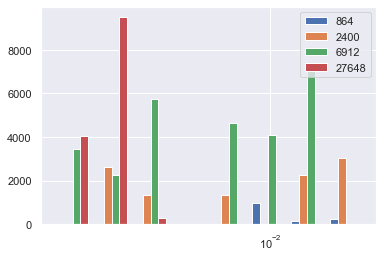

In [197]:
import matplotlib.pyplot as plt
def plot(diffs, labels):
    logbins = []
    hist, bins = np.histogram(diffs[2], bins=8)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(diffs,  
             density = False, 
             label = labels, 
             histtype='bar',
             bins=logbins)
    
    plt.legend(loc='upper right')
    plt.xscale('log')
    plt.show()
    
plot([diffs1*32, diffs2*11, diffs3*4, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])

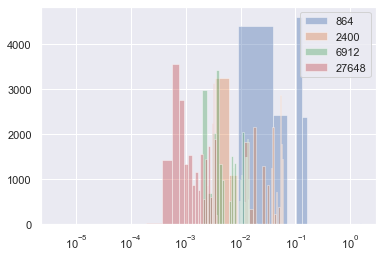

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot(diffs, labels):
    for i in range(len(diffs)):
        label = labels[i]
        x = diffs[i]
        sns.distplot(x, label=label, kde=False)
    plt.legend(loc='upper right')
    plt.xscale('log')

    plt.show()
    
plot([diffs1*16, diffs2*9, diffs3*4, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])

In [105]:
import matplotlib.pyplot as plt
def show_geo(vertices):
    stack = np.stack(vertices)
    fig = plt.figure(figsize=(15,7))
    ax = plt.axes(projection="3d")
    ax.scatter(stack[:, 0], stack[:, 1], stack[:, 2])
    plt.xlabel('x')
    plt.ylabel('y')

    print("Max x:", np.amax(stack[:, 0]))
    print("Max y:", np.amax(stack[:, 1]))
    print("Max z:", np.amax(stack[:, 2]))

    plt.show()

Vertices: 864, V1:
Vertices: 2400, V1:
Vertices: 6912, V1:
Vertices: 27648, V1:


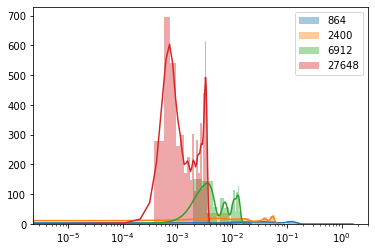

In [106]:
import matplotlib.pyplot as plt

#First torus
r1, r2 = 0.5, 0.25
pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("lowPolyTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs1 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("torusFirst.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3,)
vert_stack, curv_stack1_a, curv_stack2_a, diffs2 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("highPolyTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs3 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("ReallyHighTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs4 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)


# plot([diffs1, diffs2, diffs3, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])



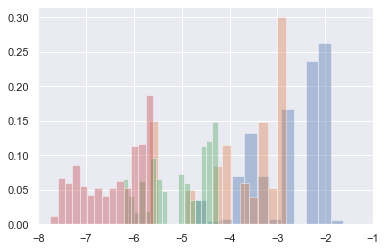

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()
def plot(diffs, labels):
    for diff,label in zip(diffs, labels):
        logdiff = np.log(diff)
        count, bins = np.histogram(logdiff, bins=8)
#         plt.hist(diff, label = label, histtype='bar')
        weights = np.ones_like(np.array(logdiff))/len(np.array(logdiff))
        sns.distplot(logdiff, hist_kws={'weights': weights}, kde=False)
#         break
        plt.xlim(-8,-1)
    plt.show()
#     plt.legend(loc='upper right')     


plot([diffs1, diffs2, diffs3, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])

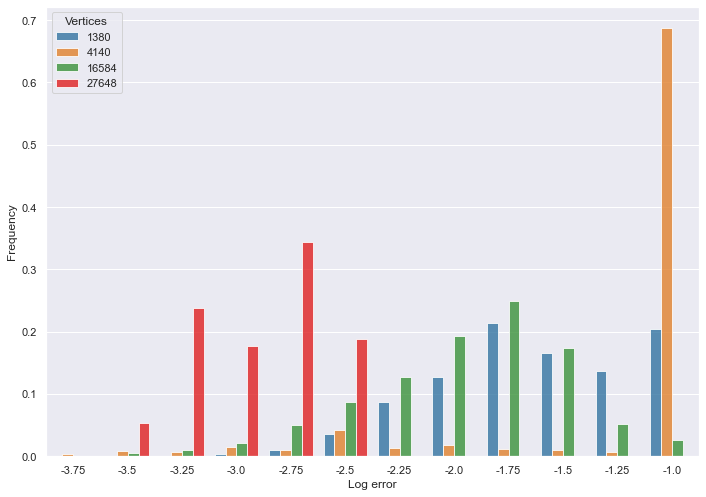

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot(diffs, labels):
    sns.set()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "red"]
    all_counts = []
    all_bins = []

    bins=[-3.75, -3.5, -3.25, -3, -2.75, -2.5, -2.25, -2, -1.75, -1.5, -1.25, -1, 0]
    all_bins=[i for i in bins[:-1]]
    
    for diff, label, color in zip(diffs, labels, colors):
        logdiff = np.log10(diff)
        count, bins = np.histogram(logdiff, bins=bins)
        count = [i/len(diff) for i in count]
        for c, b in zip(count, all_bins):
            all_counts.append([len(diff), c, b])
        
        
        #sns.barplot(x=bins[:-1], y=count, color=color, alpha=0.8)   
        #plt.bar(x=bins[:-1], height=count, color=color, alpha=0.8)
    data = pd.DataFrame(all_counts, columns = ["Vertices", "Frequency", "Log error"])
    tips = sns.load_dataset("tips")
    sns.barplot(data=data, x="Log error", y="Frequency", hue="Vertices", palette=colors, alpha=0.8, ax=ax)
    plt.show()
    
plot([diffs1, diffs2, diffs3, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])

Vertices: 1380, V1:
Vertices: 4140, V1:
Vertices: 16584, V1:


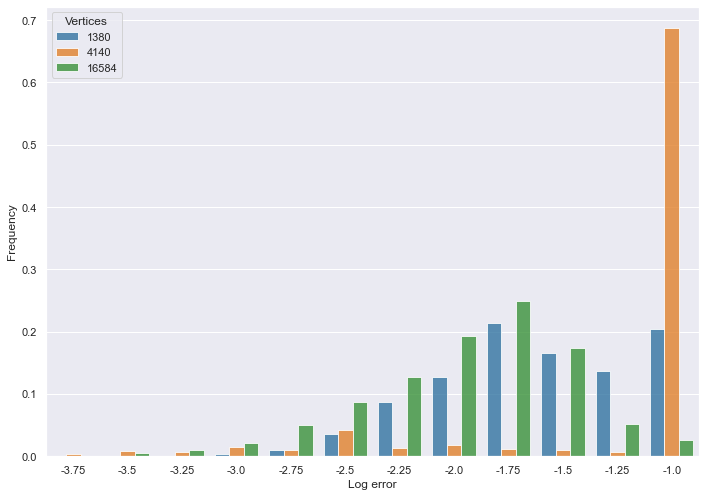

In [274]:
import matplotlib.pyplot as plt

#First torus
r1, r2 = 0.5, 0.25


pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("LowTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs1 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("MedTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3,)
vert_stack, curv_stack1_a, curv_stack2_a, diffs2 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("HighTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs3 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

plot([diffs1, diffs2, diffs3], 
     [str(len(diffs1)), str(len(diffs2)), str(len(diffs3))])


Vertices: 864, V1:
Vertices: 2400, V1:
Vertices: 6912, V1:
Vertices: 27648, V1:


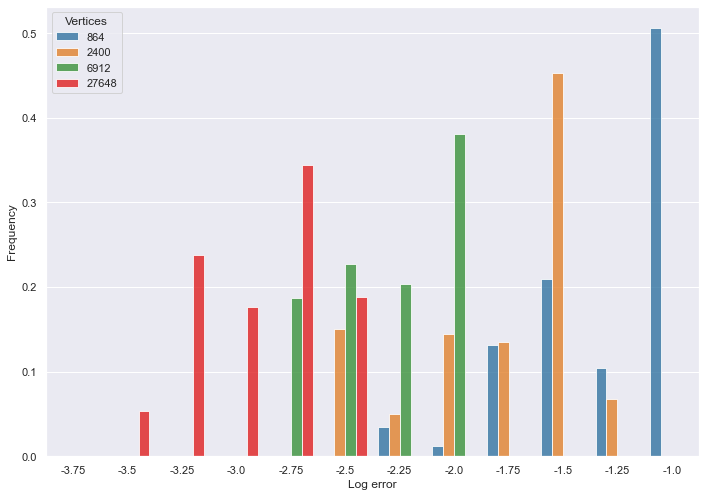

In [275]:
import matplotlib.pyplot as plt

#First torus
r1, r2 = 0.5, 0.25

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("lowPolyTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs1 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("torusFirst.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3,)
vert_stack, curv_stack1_a, curv_stack2_a, diffs2 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("highPolyTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs3 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

pds0, pds1, pds2, pds3, vertex_positions, normals = load_xml("ReallyHighTorus.xml")
vertices, unity_normals, unity_values1, unity_values2, unity_values3, unity_values4 = get_unity_values(normals, vertex_positions, pds0, pds1, pds2, pds3, True)
vert_stack, curv_stack1_a, curv_stack2_a, diffs4 = analytic_curv(r1, r2, unity_values1, unity_values2, unity_values3, unity_values4)

plot([diffs1, diffs2, diffs3, diffs4], [str(len(diffs1)), str(len(diffs2)), str(len(diffs3)), str(len(diffs4))])





In [ ]:
vert_stack = np.stack(vertices)
curv_stack1 = np.stack(unity_values1)
curv_stack2 = np.stack(unity_values2)
curv_stack3 = np.stack(unity_values3)
curv_stack4 = np.stack(unity_values4)

fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1[:,0], curv_stack1[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2[:,0], curv_stack2[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack3[:,0], curv_stack3[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack4[:,0], curv_stack4[:,1])#, headwidth=1, width=0.001, scale=60)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1[:,0], curv_stack1[:,1], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2[:,0], curv_stack2[:,1], headwidth=1, width=0.001, scale=60)

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1_a[:,0], curv_stack1_a[:,1], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2_a[:,0], curv_stack2_a[:,1], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack1[:,0], curv_stack1[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack2[:,0], curv_stack2[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack3[:,0], curv_stack3[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack4[:,0], curv_stack4[:,2], headwidth=1, width=0.001, scale=60)

ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack1_a[:,0], curv_stack1_a[:,2], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack2_a[:,0], curv_stack2_a[:,2], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))

plt.show()

In [ ]:
def plot_tangent(pp, tt1, tt2, a=75, b=0):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection="3d")
    ax.view_init(a, b)
    ax.set_proj_type('persp')
    
    ax.scatter(pp[:, 0], pp[:, 1], pp[:, 2])
    
    pp2 = np.tile(pp,(2,1))
#     ax.quiver(pp2[:,0], pp2[:,1], pp2[:,2], tt2[:,0], tt2[:,1], tt2[:,2], pivot='middle', length=0.4)
    ax.quiver(pp[:,0], pp[:,1], pp[:,2], tt1[:,0], tt1[:,1], tt1[:,2],
                colors='blue',
              pivot='middle', length=0.03)
    ax.quiver(pp[:,0], pp[:,1], pp[:,2], tt2[:,0], tt2[:,1], tt2[:,2],
                colors='red',
              pivot='middle', length=0.03)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plot_tangent(vert_stack, curv_stack1_a, curv_stack2_a)

In [ ]:
print(vert_stack[30], curv_stack1_a[30], curv_stack2_b[30])

In [ ]:
from xml.etree.ElementTree import Element, SubElement, tostring
from bs4 import BeautifulSoup

#"principalDirections0" curv_stack1_a
#"principalDirections1" curv_stack2_b
#"principalDirections2"
#"principalDirections3"
#"vertexPositions" vert_stack
normal_stack = np.stack(unity_normals)


storedCurvature = Element("StoredCurvature")

principalDirections0 = SubElement(storedCurvature, "principalDirections0")
principalDirections1 = SubElement(storedCurvature, "principalDirections1")
principalDirections2 = SubElement(storedCurvature, "principalDirections2")
principalDirections3 = SubElement(storedCurvature, "principalDirections3")
vertexPositions = SubElement(storedCurvature, "vertexPositions")
normals = SubElement(storedCurvature, "normals")


for i in range(len(vert_stack)):
    pd0 = curv_stack1_a[i]
    pd1 = curv_stack2_a[i]
    pd2 = -1*curv_stack1_a[i]
    pd3 = -1*curv_stack2_a[i]
    vert = vert_stack[i]
    normal = normal_stack[i]
    
    subelements = [vertexPositions, principalDirections0, principalDirections1, principalDirections2, principalDirections3, normals]
    values = [vert, pd0, pd1, pd2, pd3, normal]
    
    for element, value in zip(subelements, values):
        Vector3 = SubElement(element, "Vector3")
        x_comp = SubElement(Vector3, "x")
        x_comp.text = str(value[x_index])
        y_comp = SubElement(Vector3, "y")
        y_comp.text = str(value[y_index])
        z_comp = SubElement(Vector3, "z")
        z_comp.text = str(value[z_index])

xml_text = tostring(storedCurvature)
bs = BeautifulSoup(xml_text, 'xml')

with open("AnaliticFirstTorus.xml", "wb") as f:
    f.write(bs.prettify().encode())

In [ ]:
import matplotlib.pyplot as plt

X = [1, 2, 3, 0]
Y = [1, 2, 1, 0]

X[3] = (X[0] + X[1] + X[2])/3
Y[3] = (Y[0] + Y[1] + Y[2])/3

U = [0, 1, 0.7, 0]
V = [-1, 0, 0.7, 0]

U[3] = (U[0] + U[1] + U[2])/3
V[3] = (V[0] + V[1] + V[2])/3

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

plt.show()
print(U, V)